# 50 epochs

In [1]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [2]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import DatasetIN100, IN_MEAN, IN_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [3]:
learning_rate = 0.001
epochs = 50
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [4]:
prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=IN_MEAN, std=IN_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=IN_MEAN, std=IN_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load IN-100 dataset

In [5]:
train_dataset = DatasetIN100(train=True, transform=transform)
print(f"Train set size: {len(train_dataset)}")

val_dataset = DatasetIN100(train=False, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Train set size: 130000
Val set size: 5000


### Create AlexNet model

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=100).to(device)
blur_model = AlexNetSup(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()

clear_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)

steps = len(train_loader)

# Learning rate scheduler for clear model
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])

# Learning rate scheduler for blurry-to-clear model
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
logs_blur = []

clear_model.eval()
blur_model.eval()

# Training metrics initialization
clear_train_corr, blur_train_corr, total_train = 0, 0, 0
clear_train_loss, blur_train_loss = 0.0, 0.0

with torch.no_grad():
    for images, labels in train_loader:
        # Apply blur transformation
        blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Get predictions from both models
        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(blurred_images)

        # Calculate loss values
        clear_loss = criterion(clear_y_pred, labels)
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100
clear_train_loss /= total_train
blur_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, blur_val_corr, total_val = 0, 0, 0
clear_val_loss, blur_val_loss = 0.0, 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100
clear_val_loss /= total_val
blur_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
blur_train_loss_list.append(blur_train_loss)
clear_val_loss_list.append(clear_val_loss)
blur_val_loss_list.append(blur_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

blur_log_entry = (f"Epoch 0/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs_blur.append(blur_log_entry)

Epoch 0/50, Clear train acc: 0.9689%, Clear train loss: 4.6087, Clear val acc: 1.05%, Clear val loss: 4.6148
Epoch 0/50, Blur train acc: 1.0665%, Blur train loss: 4.6100, Blur val acc: 1.25%, Blur val loss: 4.6167


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 10:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 30:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for images, labels in train_loader:
            if epoch < 10:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 30:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,  # Optionally log training loss from the training loop
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/50, Clear train acc: 7.9898%, Clear train loss: 4.0876, Clear val acc: 7.81%, Clear val loss: 3.9947
Epoch 1/50, Blur train acc: 6.2988%, Blur train loss: 4.2286, Blur val acc: 7.40%, Blur val loss: 4.1352
Epoch 2/50, Clear train acc: 12.0348%, Clear train loss: 3.8479, Clear val acc: 14.08%, Clear val loss: 3.7317
Epoch 2/50, Blur train acc: 9.7142%, Blur train loss: 4.0285, Blur val acc: 10.59%, Blur val loss: 3.8963
Epoch 3/50, Clear train acc: 16.9151%, Clear train loss: 3.5837, Clear val acc: 18.75%, Clear val loss: 3.4523
Epoch 3/50, Blur train acc: 12.9909%, Blur train loss: 3.8210, Blur val acc: 12.91%, Blur val loss: 3.8017
Epoch 4/50, Clear train acc: 21.2659%, Clear train loss: 3.3306, Clear val acc: 23.40%, Clear val loss: 3.1968
Epoch 4/50, Blur train acc: 15.9360%, Blur train loss: 3.6398, Blur val acc: 11.53%, Blur val loss: 4.6921
Epoch 5/50, Clear train acc: 25.5422%, Clear train loss: 3.1017, Clear val acc: 26.03%, Clear val loss: 3.0311
Epoch 5/50, Blur train

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

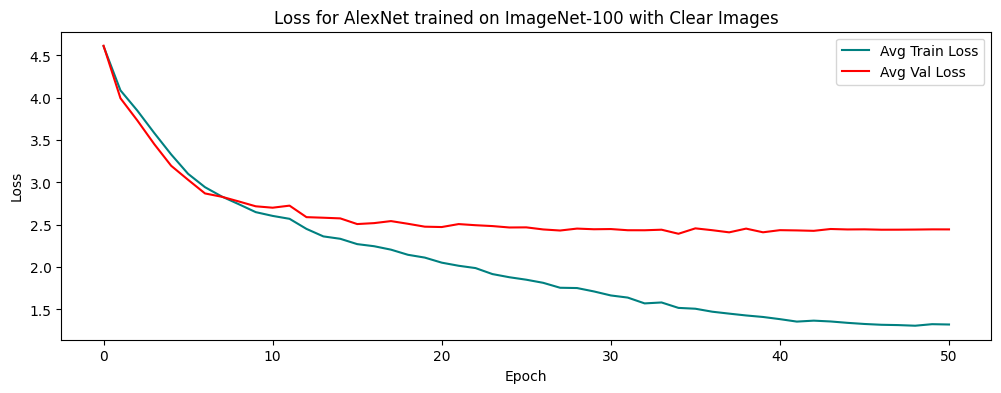

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-100 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

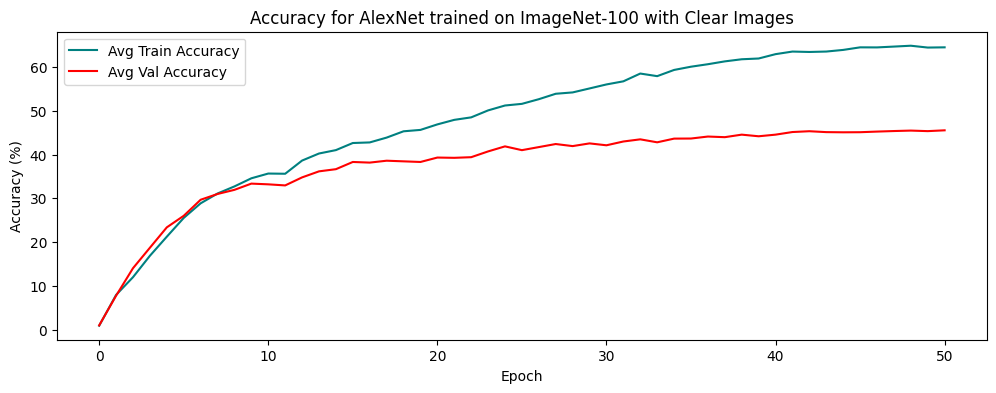

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-100 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

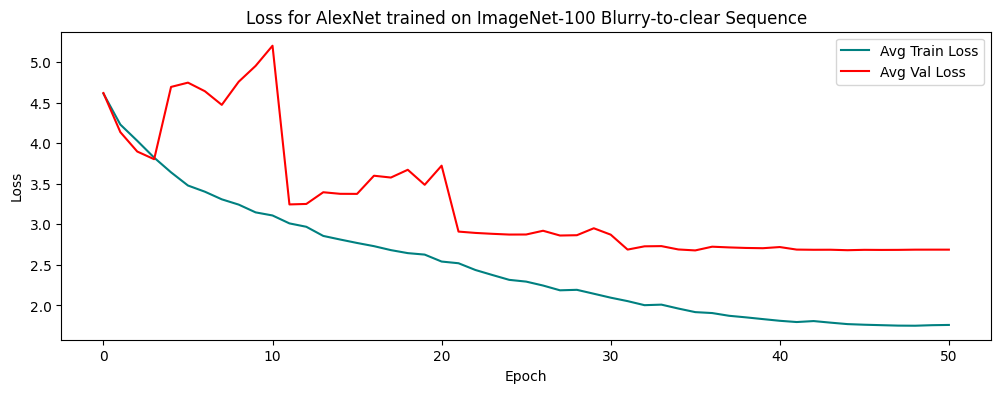

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-100 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

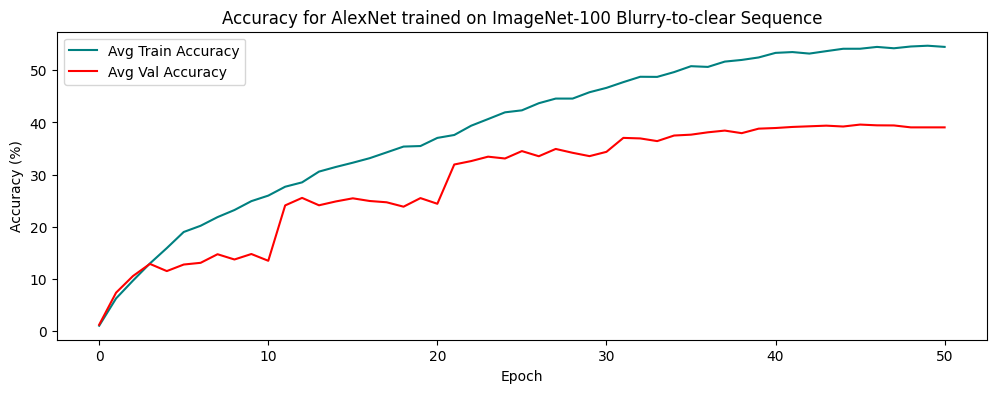

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-100 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# 100 epochs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src


In [ ]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import DatasetIN100, IN_MEAN, IN_STD
from torch.utils.data import DataLoader

### Set hyperparameters

In [ ]:
learning_rate = 0.001
epochs = 100
batch_size = 256
output_dir_clear = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_clear"
output_dir_blur = "/content/drive/MyDrive/ug-project/output/alexnet/100_epochs/IN100_blur"

os.makedirs(output_dir_clear, exist_ok=True)
os.makedirs(output_dir_blur, exist_ok=True)

### Define transforms

In [ ]:
prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=IN_MEAN, std=IN_STD),
                        v2.RandomErasing(p=0.5)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(mean=IN_MEAN, std=IN_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load IN-100 dataset

In [ ]:
train_dataset = DatasetIN100(train=True, transform=transform)
print(f"Train set size: {len(train_dataset)}")

val_dataset = DatasetIN100(train=False, transform=transform_test)
print(f"Val set size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Train set size: 130000
Val set size: 5000


### Create AlexNet model

In [ ]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = AlexNetSup(num_classes=100).to(device)
blur_model = AlexNetSup(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()

clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)

steps = len(train_loader)

# Learning rate scheduler for clear model
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])

# Learning rate scheduler for blurry-to-clear model
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [ ]:
!pip install kornia

In [ ]:
from utils import add_blur_with

# Initialize metrics for plotting
clear_train_correct, clear_val_correct = [], []
#blur_train_correct, blur_val_correct = [], []
clear_train_loss_list, clear_val_loss_list = [], []
#blur_train_loss_list, blur_val_loss_list = [], []
logs_clear = []
#logs_blur = []

clear_model.eval()
#blur_model.eval()

# Training metrics initialization
clear_train_corr, total_train = 0, 0
clear_train_loss = 0.0

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        clear_y_pred = clear_model(images)

        clear_loss = criterion(clear_y_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_train_loss += clear_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
clear_train_accuracy = (clear_train_corr / total_train) * 100
clear_train_loss /= total_train

# Validation metrics initialization
clear_val_corr, total_val = 0, 0
clear_val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        clear_y_val_pred = clear_model(images)

        # Calculate loss values for validation set
        clear_loss = criterion(clear_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        clear_val_loss += clear_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
clear_val_accuracy = (clear_val_corr / total_val) * 100
clear_val_loss /= total_val

# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
clear_train_loss_list.append(clear_train_loss)
clear_val_loss_list.append(clear_val_loss)

# Log entry with both accuracy and loss values
clear_log_entry = (f"Epoch 0/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss:.4f}")
print(clear_log_entry)
logs_clear.append(clear_log_entry)

Epoch 0/100, Clear train acc: 1.0324%, Clear train loss: 4.6154, Clear val acc: 1.09%, Clear val loss: 4.6125


### Training loop

In [ ]:
for epoch in range(0, 50):

    ###################### Train model #########################
    clear_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        clear_optimizer.step()
        clear_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    clear_train_corr, total_train = 0, 0
    clear_train_loss_eval = 0.0

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, total_val = 0, 0
    clear_val_loss_sum = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,  # Optionally log training loss from the training loop
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

Epoch 1/100, Clear train acc: 17.3824%, Clear train loss: 3.5512, Clear val acc: 19.98%, Clear val loss: 3.3763
Epoch 2/100, Clear train acc: 25.8637%, Clear train loss: 3.1073, Clear val acc: 28.12%, Clear val loss: 2.9389
Epoch 3/100, Clear train acc: 31.6761%, Clear train loss: 2.8041, Clear val acc: 33.35%, Clear val loss: 2.6707
Epoch 4/100, Clear train acc: 36.7080%, Clear train loss: 2.5581, Clear val acc: 38.96%, Clear val loss: 2.4281
Epoch 5/100, Clear train acc: 38.6203%, Clear train loss: 2.4656, Clear val acc: 41.10%, Clear val loss: 2.3973
Epoch 6/100, Clear train acc: 41.3508%, Clear train loss: 2.3461, Clear val acc: 42.80%, Clear val loss: 2.3157
Epoch 7/100, Clear train acc: 41.6513%, Clear train loss: 2.3163, Clear val acc: 43.77%, Clear val loss: 2.2413
Epoch 8/100, Clear train acc: 43.5227%, Clear train loss: 2.2231, Clear val acc: 45.13%, Clear val loss: 2.1842
Epoch 9/100, Clear train acc: 42.9557%, Clear train loss: 2.2581, Clear val acc: 44.47%, Clear val loss:

In [ ]:
import os
import torch
from utils import add_blur_with

# Load checkpoint if resuming from epoch 50
start_epoch = 50

blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{start_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {start_epoch}...")

    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])

    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Restore schedulers by advancing their steps
    for _ in range(start_epoch * len(train_loader)):
        blur_combined_scheduler.step()

    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode first to check if weights are loaded properly
blur_model.eval()

# Run a quick validation check before resuming training
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)

        blur_predicted = torch.max(blur_pred, 1)[1]

        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100

print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")

Loading checkpoint from epoch 50...
Successfully resumed training from epoch 50.


<ipython-input-19-588cf414a9e0>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)


Validation Accuracy after checkpoint load - Blur Model: 33.45%


In [ ]:
import re

text = """
Epoch 1/100, Clear train acc: 1.0093%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 1/100, Blur train acc: 12.3120%, Blur train loss: 3.8535, Blur val acc: 13.22%, Blur val loss: 4.0090
Epoch 2/100, Clear train acc: 1.0093%, Clear train loss: 4.6136, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 2/100, Blur train acc: 14.8253%, Blur train loss: 3.7359, Blur val acc: 11.66%, Blur val loss: 5.1094
Epoch 3/100, Clear train acc: 1.0162%, Clear train loss: 4.6136, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 3/100, Blur train acc: 18.1367%, Blur train loss: 3.5297, Blur val acc: 10.65%, Blur val loss: 5.1723
Epoch 4/100, Clear train acc: 1.0132%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 4/100, Blur train acc: 19.3209%, Blur train loss: 3.4811, Blur val acc: 12.46%, Blur val loss: 4.6754
Epoch 5/100, Clear train acc: 1.0178%, Clear train loss: 4.6140, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 5/100, Blur train acc: 20.1815%, Blur train loss: 3.4180, Blur val acc: 10.42%, Blur val loss: 5.1942
Epoch 6/100, Clear train acc: 1.0124%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 6/100, Blur train acc: 21.5345%, Blur train loss: 3.3400, Blur val acc: 10.63%, Blur val loss: 5.4562
Epoch 7/100, Clear train acc: 1.0286%, Clear train loss: 4.6140, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 7/100, Blur train acc: 21.5329%, Blur train loss: 3.3339, Blur val acc: 8.76%, Blur val loss: 6.8889
Epoch 8/100, Clear train acc: 1.0424%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 8/100, Blur train acc: 22.4806%, Blur train loss: 3.2966, Blur val acc: 11.33%, Blur val loss: 5.3210
Epoch 9/100, Clear train acc: 1.0363%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 9/100, Blur train acc: 22.0915%, Blur train loss: 3.3054, Blur val acc: 9.50%, Blur val loss: 6.0307
Epoch 10/100, Clear train acc: 1.0355%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 10/100, Blur train acc: 23.0877%, Blur train loss: 3.2622, Blur val acc: 10.05%, Blur val loss: 5.9545
Epoch 11/100, Clear train acc: 1.0101%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 11/100, Blur train acc: 23.6632%, Blur train loss: 3.2402, Blur val acc: 10.38%, Blur val loss: 6.4514
Epoch 12/100, Clear train acc: 1.0170%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 12/100, Blur train acc: 24.6309%, Blur train loss: 3.1716, Blur val acc: 8.16%, Blur val loss: 6.5735
Epoch 13/100, Clear train acc: 1.0132%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 13/100, Blur train acc: 24.9723%, Blur train loss: 3.1640, Blur val acc: 9.23%, Blur val loss: 6.5049
Epoch 14/100, Clear train acc: 1.0024%, Clear train loss: 4.6141, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 14/100, Blur train acc: 25.3814%, Blur train loss: 3.1364, Blur val acc: 8.53%, Blur val loss: 6.0693
Epoch 15/100, Clear train acc: 1.0001%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 15/100, Blur train acc: 24.8898%, Blur train loss: 3.1661, Blur val acc: 7.57%, Blur val loss: 6.6946
Epoch 16/100, Clear train acc: 1.0201%, Clear train loss: 4.6136, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 16/100, Blur train acc: 25.5131%, Blur train loss: 3.1475, Blur val acc: 9.72%, Blur val loss: 6.2346
Epoch 17/100, Clear train acc: 1.0270%, Clear train loss: 4.6135, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 17/100, Blur train acc: 25.9384%, Blur train loss: 3.1119, Blur val acc: 8.68%, Blur val loss: 5.9715
Epoch 18/100, Clear train acc: 1.0070%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 18/100, Blur train acc: 26.6372%, Blur train loss: 3.0749, Blur val acc: 7.32%, Blur val loss: 8.0320
Epoch 19/100, Clear train acc: 1.0155%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 19/100, Blur train acc: 27.2829%, Blur train loss: 3.0325, Blur val acc: 8.88%, Blur val loss: 6.9754
Epoch 20/100, Clear train acc: 1.0031%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 20/100, Blur train acc: 27.1326%, Blur train loss: 3.0591, Blur val acc: 8.04%, Blur val loss: 7.5748
Epoch 21/100, Clear train acc: 1.0255%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 21/100, Blur train acc: 27.6350%, Blur train loss: 3.0272, Blur val acc: 20.87%, Blur val loss: 3.5213
Epoch 22/100, Clear train acc: 1.0278%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 22/100, Blur train acc: 28.7691%, Blur train loss: 2.9682, Blur val acc: 21.67%, Blur val loss: 3.5139
Epoch 23/100, Clear train acc: 1.0340%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 23/100, Blur train acc: 28.5503%, Blur train loss: 2.9672, Blur val acc: 20.76%, Blur val loss: 3.5690
Epoch 24/100, Clear train acc: 1.0201%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 24/100, Blur train acc: 29.8223%, Blur train loss: 2.9122, Blur val acc: 20.50%, Blur val loss: 3.6709
Epoch 25/100, Clear train acc: 1.0186%, Clear train loss: 4.6136, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 25/100, Blur train acc: 30.5882%, Blur train loss: 2.8649, Blur val acc: 22.31%, Blur val loss: 3.4963
Epoch 26/100, Clear train acc: 1.0108%, Clear train loss: 4.6136, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 26/100, Blur train acc: 31.2500%, Blur train loss: 2.8441, Blur val acc: 17.45%, Blur val loss: 4.0162
Epoch 27/100, Clear train acc: 1.0239%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 27/100, Blur train acc: 31.7138%, Blur train loss: 2.8135, Blur val acc: 16.30%, Blur val loss: 4.5531
Epoch 28/100, Clear train acc: 1.0062%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 28/100, Blur train acc: 32.0836%, Blur train loss: 2.7879, Blur val acc: 20.35%, Blur val loss: 3.8663
Epoch 29/100, Clear train acc: 1.0324%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 29/100, Blur train acc: 32.9936%, Blur train loss: 2.7562, Blur val acc: 17.91%, Blur val loss: 4.2318
Epoch 30/100, Clear train acc: 1.0055%, Clear train loss: 4.6140, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 30/100, Blur train acc: 32.8225%, Blur train loss: 2.7661, Blur val acc: 19.76%, Blur val loss: 3.8594
Epoch 31/100, Clear train acc: 1.0255%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 31/100, Blur train acc: 33.8742%, Blur train loss: 2.7141, Blur val acc: 14.84%, Blur val loss: 5.1907
Epoch 32/100, Clear train acc: 1.0132%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 32/100, Blur train acc: 33.6115%, Blur train loss: 2.7173, Blur val acc: 18.69%, Blur val loss: 4.1597
Epoch 33/100, Clear train acc: 1.0124%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 33/100, Blur train acc: 33.1831%, Blur train loss: 2.7408, Blur val acc: 14.37%, Blur val loss: 5.2024
Epoch 34/100, Clear train acc: 1.0293%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 34/100, Blur train acc: 34.7988%, Blur train loss: 2.6652, Blur val acc: 16.24%, Blur val loss: 4.3669
Epoch 35/100, Clear train acc: 1.0155%, Clear train loss: 4.6136, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 35/100, Blur train acc: 34.3496%, Blur train loss: 2.6933, Blur val acc: 18.15%, Blur val loss: 4.0337
Epoch 36/100, Clear train acc: 1.0101%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 36/100, Blur train acc: 34.7048%, Blur train loss: 2.6713, Blur val acc: 13.80%, Blur val loss: 5.4429
Epoch 37/100, Clear train acc: 1.0132%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 37/100, Blur train acc: 35.7341%, Blur train loss: 2.6153, Blur val acc: 17.66%, Blur val loss: 4.2523
Epoch 38/100, Clear train acc: 1.0139%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 38/100, Blur train acc: 35.2225%, Blur train loss: 2.6443, Blur val acc: 14.74%, Blur val loss: 4.5001
Epoch 39/100, Clear train acc: 1.0055%, Clear train loss: 4.6141, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 39/100, Blur train acc: 36.5439%, Blur train loss: 2.5758, Blur val acc: 15.17%, Blur val loss: 4.8043
Epoch 40/100, Clear train acc: 1.0047%, Clear train loss: 4.6140, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 40/100, Blur train acc: 36.4352%, Blur train loss: 2.5959, Blur val acc: 18.34%, Blur val loss: 4.4599
Epoch 41/100, Clear train acc: 1.0093%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 41/100, Blur train acc: 37.5300%, Blur train loss: 2.5249, Blur val acc: 34.44%, Blur val loss: 2.7546
Epoch 42/100, Clear train acc: 1.0255%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 42/100, Blur train acc: 37.6048%, Blur train loss: 2.5245, Blur val acc: 32.55%, Blur val loss: 2.8683
Epoch 43/100, Clear train acc: 1.0093%, Clear train loss: 4.6140, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 43/100, Blur train acc: 38.3244%, Blur train loss: 2.4982, Blur val acc: 32.15%, Blur val loss: 2.9872
Epoch 44/100, Clear train acc: 1.0286%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 44/100, Blur train acc: 39.3514%, Blur train loss: 2.4416, Blur val acc: 34.23%, Blur val loss: 2.8234
Epoch 45/100, Clear train acc: 1.0201%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 45/100, Blur train acc: 40.3268%, Blur train loss: 2.3948, Blur val acc: 35.55%, Blur val loss: 2.7401
Epoch 46/100, Clear train acc: 1.0509%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 46/100, Blur train acc: 40.3746%, Blur train loss: 2.3892, Blur val acc: 35.42%, Blur val loss: 2.7230
Epoch 47/100, Clear train acc: 1.0247%, Clear train loss: 4.6139, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 47/100, Blur train acc: 40.5117%, Blur train loss: 2.3868, Blur val acc: 35.18%, Blur val loss: 2.7620
Epoch 48/100, Clear train acc: 1.0193%, Clear train loss: 4.6137, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 48/100, Blur train acc: 40.9902%, Blur train loss: 2.3601, Blur val acc: 35.07%, Blur val loss: 2.7059
Epoch 49/100, Clear train acc: 1.0047%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 49/100, Blur train acc: 41.7776%, Blur train loss: 2.3181, Blur val acc: 33.80%, Blur val loss: 2.8369
Epoch 50/100, Clear train acc: 1.0193%, Clear train loss: 4.6138, Clear val acc: 1.03%, Clear val loss: 4.6136
Epoch 50/100, Blur train acc: 42.1644%, Blur train loss: 2.2995, Blur val acc: 33.45%, Blur val loss: 2.8661
"""

pattern_blur = r"Blur train acc: ([\d.]+)%, Blur train loss: ([\d.]+), Blur val acc: ([\d.]+)%, Blur val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
lines = text.strip().split("\n")

# Separate lines into logs_clear and logs_blur based on alternating pattern
logs_blur = [line for i, line in enumerate(lines) if i % 2 == 1]

In [ ]:
for epoch in range(start_epoch, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    clear_train_loss_sum, blur_train_loss_sum = 0.0, 0.0
    train_samples = 0

    for images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch < 60:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch < 80:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        else:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)

        # Zero the parameter gradients
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()

        # Forward passes
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)

        # Compute losses
        clear_loss = criterion(clear_logits, labels)
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        clear_loss.backward()
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        clear_train_loss_sum += clear_loss.item() * batch_size
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    clear_train_loss_epoch = clear_train_loss_sum / train_samples
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0
    clear_train_loss_eval, blur_train_loss_eval = 0.0, 0.0

    with torch.no_grad():
        for images, labels in train_loader:
            if epoch < 20:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            elif epoch < 40:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
            elif epoch < 60:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
            elif epoch < 80:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
            else:
                blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])
            blurred_images, labels = blurred_images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(blurred_images)

            # Calculate loss on the training set (evaluation mode)
            clear_loss_eval = criterion(clear_y_pred, labels)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_train_loss_eval += clear_loss_eval.item() * batch_size
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100
    clear_train_loss_avg = clear_train_loss_eval / total_train
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0
    clear_val_loss_sum, blur_val_loss_sum = 0.0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)

            # Compute validation losses
            clear_loss_val = criterion(clear_y_pred, labels)
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            clear_val_loss_sum += clear_loss_val.item() * batch_size
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100
    clear_val_loss_avg = clear_val_loss_sum / total_val
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    clear_train_loss_list.append(clear_train_loss_avg)
    blur_train_loss_list.append(blur_train_loss_avg)
    clear_val_loss_list.append(clear_val_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    clear_log_entry = (f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear train loss: {clear_train_loss_avg:.4f}, Clear val acc: {clear_val_accuracy:.2f}%, Clear val loss: {clear_val_loss_avg:.4f}")
    print(clear_log_entry)
    logs_clear.append(clear_log_entry)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Blur train acc: {blur_train_accuracy:.4f}%, Blur train loss: {blur_train_loss_avg:.4f}, Blur val acc: {blur_val_accuracy:.2f}%, Blur val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs_blur.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        clear_checkpoint_path = os.path.join(output_dir_clear, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_clear = {
            'epoch': epoch+1,
            'model_state_dict': clear_model.state_dict(),
            'optimizer_state_dict': clear_optimizer.state_dict(),
            'train_accuracy': clear_train_accuracy,
            'train_loss': clear_train_loss_epoch,  # Optionally log training loss from the training loop
        }
        torch.save(checkpoint_clear, clear_checkpoint_path)

        blur_checkpoint_path = os.path.join(output_dir_blur, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 51/100, Clear train acc: 61.5701%, Clear train loss: 1.4271, Clear val acc: 58.29%, Clear val loss: 1.6791
Epoch 51/100, Blur train acc: 45.5097%, Blur train loss: 2.1482, Blur val acc: 35.57%, Blur val loss: 2.8333
Epoch 52/100, Clear train acc: 62.6094%, Clear train loss: 1.3826, Clear val acc: 58.66%, Clear val loss: 1.6838
Epoch 52/100, Blur train acc: 46.1315%, Blur train loss: 2.1233, Blur val acc: 36.06%, Blur val loss: 2.7881
Epoch 53/100, Clear train acc: 62.8852%, Clear train loss: 1.3665, Clear val acc: 59.46%, Clear val loss: 1.6399
Epoch 53/100, Blur train acc: 46.7525%, Blur train loss: 2.0835, Blur val acc: 34.91%, Blur val loss: 2.8952
Epoch 54/100, Clear train acc: 63.2119%, Clear train loss: 1.3583, Clear val acc: 59.87%, Clear val loss: 1.6228
Epoch 54/100, Blur train acc: 47.1108%, Blur train loss: 2.0695, Blur val acc: 35.92%, Blur val loss: 2.7709
Epoch 55/100, Clear train acc: 62.9962%, Clear train loss: 1.3614, Clear val acc: 58.82%, Clear val loss: 1.6473

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir_clear}/training_log.txt", 'w') as log_file:
    for log_entry in logs_clear:
        log_file.write(log_entry + '\n')

with open(f"{output_dir_blur}/training_log.txt", 'w') as log_file:
    for log_entry in logs_blur:
        log_file.write(log_entry + '\n')

clear_metrics = {
    'clear_train_correct': clear_train_correct,
    'clear_val_correct': clear_val_correct,
    'clear_train_loss_list': clear_train_loss_list,
    'clear_val_loss_list': clear_val_loss_list
}
blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir_clear}/metrics.pkl", "wb") as clear_metrics_file:
    pickle.dump(clear_metrics, clear_metrics_file)

with open(f"{output_dir_blur}/metrics.pkl", "wb") as blur_metrics_file:
    pickle.dump(blur_metrics, blur_metrics_file)

### Plot clear loss and accuracy

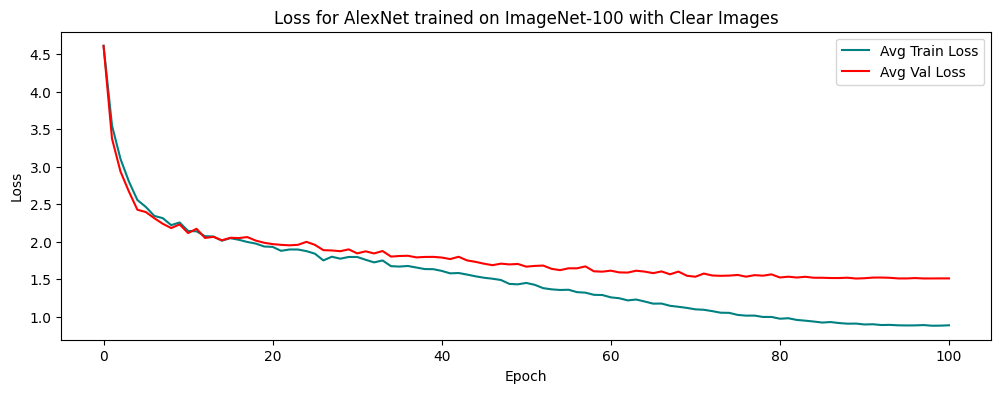

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(clear_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(clear_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-100 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

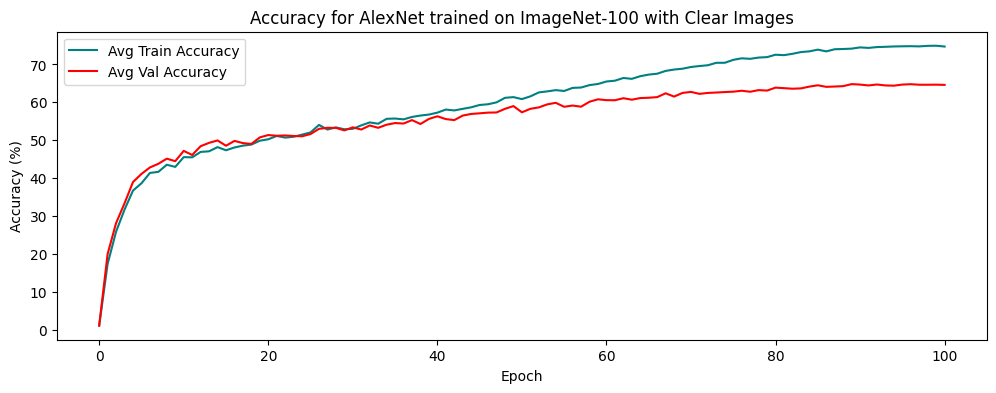

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-100 with Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blurry-to-clear loss and accuracy

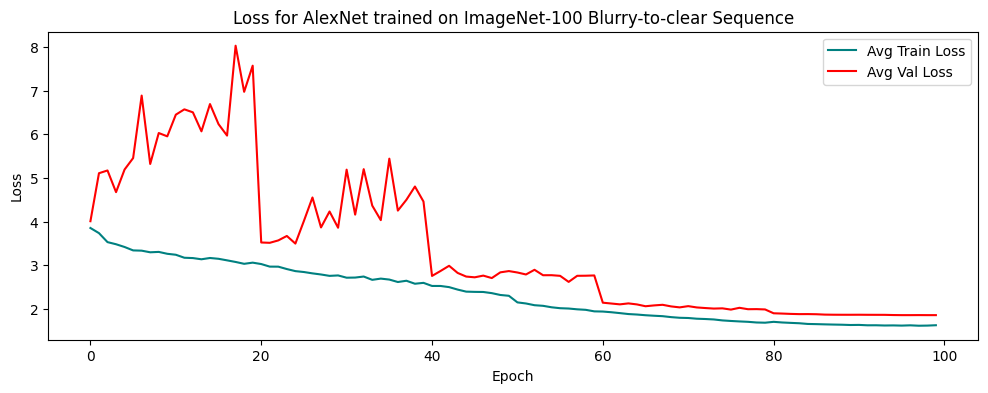

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on ImageNet-100 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

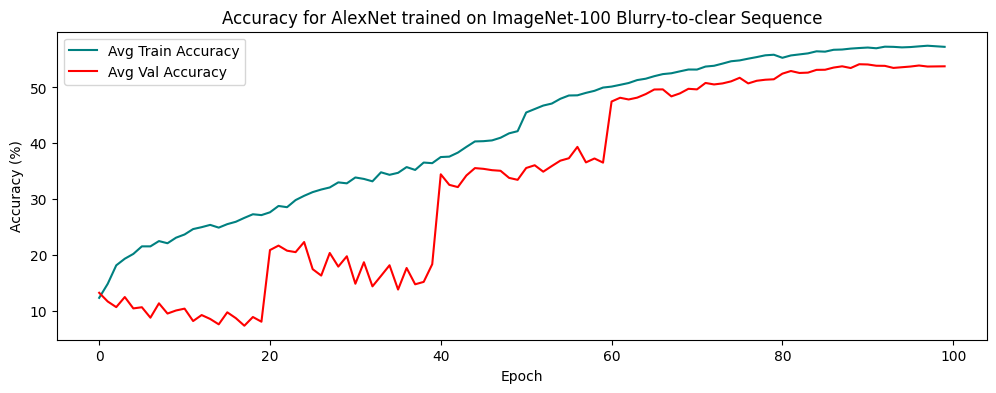

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on ImageNet-100 Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Full blur training

In [6]:
epochs = 100
batch_size = 256
learning_rate = 0.001
output_dir = "/content/drive/MyDrive/ug-project/output/alexnet/full_blur/IN100_full_blur_2"

os.makedirs(output_dir, exist_ok=True)

In [7]:
import torch
import torch.nn as nn
from model import AlexNetSup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

blur_model = AlexNetSup(num_classes=100).to(device)

criterion = nn.CrossEntropyLoss()
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=0.0001)
steps = len(train_loader)

blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

In [8]:
!pip install kornia

In [9]:
from utils import add_blur_with

# Initialize metrics for plotting
blur_train_correct, blur_val_correct = [], []
blur_train_loss_list, blur_val_loss_list = [], []
logs = []

blur_model.eval()

# Training metrics initialization
blur_train_corr, total_train = 0, 0
blur_train_loss = 0.0

with torch.no_grad():
    for images, labels in train_loader:
        # Apply blur transformation
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        blur_y_pred = blur_model(images)

        # Calculate loss values
        blur_loss = criterion(blur_y_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_train_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

# Average accuracy and loss over all training samples
blur_train_accuracy = (blur_train_corr / total_train) * 100
blur_train_loss /= total_train

# Validation metrics initialization
blur_val_corr, total_val = 0, 0
blur_val_loss = 0.0

with torch.no_grad():
    for images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Get predictions from both models on validation data
        blur_y_val_pred = blur_model(images)

        # Calculate loss values for validation set
        blur_loss = criterion(blur_y_val_pred, labels)

        # Accumulate total loss weighted by batch size
        blur_val_loss += blur_loss.item() * labels.size(0)

        # Compute accuracy for current batch
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

# Average accuracy and loss over all validation samples
blur_val_accuracy = (blur_val_corr / total_val) * 100
blur_val_loss /= total_val

# Save results for plotting
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)
blur_train_loss_list.append(blur_train_loss)
blur_val_loss_list.append(blur_val_loss)

blur_log_entry = (f"Epoch 0/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss:.4f}")
print(blur_log_entry)
logs.append(blur_log_entry)

Epoch 0/100, Train acc: 1.0216%, Train loss: 4.6073, Val acc: 1.11%, Val loss: 4.6058


### Training loop

In [ ]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'scheduler_state_dict': blur_combined_scheduler.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 1/100, Train acc: 12.7928%, Train loss: 3.8166, Val acc: 14.35%, Val loss: 3.6429
Epoch 2/100, Train acc: 17.4726%, Train loss: 3.5394, Val acc: 19.16%, Val loss: 3.3685
Epoch 3/100, Train acc: 21.7325%, Train loss: 3.3134, Val acc: 24.94%, Val loss: 3.1130
Epoch 4/100, Train acc: 24.0693%, Train loss: 3.2011, Val acc: 27.73%, Val loss: 3.0346
Epoch 5/100, Train acc: 26.5201%, Train loss: 3.0886, Val acc: 28.89%, Val loss: 2.9470
Epoch 6/100, Train acc: 28.0842%, Train loss: 3.0179, Val acc: 30.65%, Val loss: 2.8727
Epoch 7/100, Train acc: 29.1243%, Train loss: 2.9336, Val acc: 31.37%, Val loss: 2.8277
Epoch 8/100, Train acc: 29.4479%, Train loss: 2.9236, Val acc: 31.33%, Val loss: 2.8041
Epoch 9/100, Train acc: 30.9148%, Train loss: 2.8555, Val acc: 32.63%, Val loss: 2.7409
Epoch 10/100, Train acc: 32.1014%, Train loss: 2.8026, Val acc: 33.88%, Val loss: 2.6984
Epoch 11/100, Train acc: 32.6476%, Train loss: 2.7574, Val acc: 33.96%, Val loss: 2.6750
Epoch 12/100, Train acc: 33.52

In [ ]:
import re

text = """
Epoch 0/50, Train acc: 1.0347%, Train loss: 4.6082, Val acc: 0.93%, Val loss: 4.6059
Epoch 1/50, Train acc: 11.7442%, Train loss: 3.8879, Val acc: 14.51%, Val loss: 3.7153
Epoch 2/50, Train acc: 17.7877%, Train loss: 3.5558, Val acc: 20.64%, Val loss: 3.3481
Epoch 3/50, Train acc: 21.1192%, Train loss: 3.3606, Val acc: 23.44%, Val loss: 3.1959
Epoch 4/50, Train acc: 25.1187%, Train loss: 3.1556, Val acc: 27.80%, Val loss: 2.9877
Epoch 5/50, Train acc: 25.2820%, Train loss: 3.1193, Val acc: 27.69%, Val loss: 2.9930
Epoch 6/50, Train acc: 27.7868%, Train loss: 3.0135, Val acc: 30.74%, Val loss: 2.8536
Epoch 7/50, Train acc: 29.9194%, Train loss: 2.9033, Val acc: 30.98%, Val loss: 2.8099
Epoch 8/50, Train acc: 30.7947%, Train loss: 2.8572, Val acc: 32.48%, Val loss: 2.7365
Epoch 9/50, Train acc: 31.5135%, Train loss: 2.8300, Val acc: 34.64%, Val loss: 2.7253
Epoch 10/50, Train acc: 31.5297%, Train loss: 2.8119, Val acc: 33.96%, Val loss: 2.7263
Epoch 11/50, Train acc: 32.9520%, Train loss: 2.7518, Val acc: 34.64%, Val loss: 2.6836
Epoch 12/50, Train acc: 33.6955%, Train loss: 2.7176, Val acc: 35.09%, Val loss: 2.6564
Epoch 13/50, Train acc: 34.5222%, Train loss: 2.6768, Val acc: 35.03%, Val loss: 2.6452
Epoch 14/50, Train acc: 34.8565%, Train loss: 2.6502, Val acc: 36.12%, Val loss: 2.5902
Epoch 15/50, Train acc: 35.7849%, Train loss: 2.6045, Val acc: 36.20%, Val loss: 2.5816
Epoch 16/50, Train acc: 37.0431%, Train loss: 2.5565, Val acc: 37.60%, Val loss: 2.5805
Epoch 17/50, Train acc: 37.6217%, Train loss: 2.5210, Val acc: 37.48%, Val loss: 2.5364
Epoch 18/50, Train acc: 38.2204%, Train loss: 2.4894, Val acc: 37.81%, Val loss: 2.4957
Epoch 19/50, Train acc: 38.6018%, Train loss: 2.4729, Val acc: 38.57%, Val loss: 2.4914
Epoch 20/50, Train acc: 39.7390%, Train loss: 2.4166, Val acc: 39.06%, Val loss: 2.4872
Epoch 21/50, Train acc: 40.3430%, Train loss: 2.4007, Val acc: 39.17%, Val loss: 2.4475
Epoch 22/50, Train acc: 40.3592%, Train loss: 2.3800, Val acc: 39.99%, Val loss: 2.4080
Epoch 23/50, Train acc: 42.0080%, Train loss: 2.3223, Val acc: 40.25%, Val loss: 2.4099
Epoch 24/50, Train acc: 41.8523%, Train loss: 2.3208, Val acc: 40.87%, Val loss: 2.3755
Epoch 25/50, Train acc: 42.6945%, Train loss: 2.2764, Val acc: 41.45%, Val loss: 2.3386
Epoch 26/50, Train acc: 43.1352%, Train loss: 2.2572, Val acc: 41.82%, Val loss: 2.3494
Epoch 27/50, Train acc: 44.3702%, Train loss: 2.1962, Val acc: 42.80%, Val loss: 2.3100
Epoch 28/50, Train acc: 44.7585%, Train loss: 2.1849, Val acc: 42.62%, Val loss: 2.2716
Epoch 29/50, Train acc: 45.4412%, Train loss: 2.1549, Val acc: 43.30%, Val loss: 2.2815
Epoch 30/50, Train acc: 46.1485%, Train loss: 2.1258, Val acc: 43.54%, Val loss: 2.2720
Epoch 31/50, Train acc: 46.2810%, Train loss: 2.1151, Val acc: 43.73%, Val loss: 2.2783
Epoch 32/50, Train acc: 46.7140%, Train loss: 2.0947, Val acc: 43.54%, Val loss: 2.2510
Epoch 33/50, Train acc: 47.6277%, Train loss: 2.0479, Val acc: 44.31%, Val loss: 2.2259
Epoch 34/50, Train acc: 48.1732%, Train loss: 2.0274, Val acc: 44.80%, Val loss: 2.2323
Epoch 35/50, Train acc: 48.9683%, Train loss: 1.9925, Val acc: 45.54%, Val loss: 2.2011
Epoch 36/50, Train acc: 49.2812%, Train loss: 1.9771, Val acc: 45.95%, Val loss: 2.1840
Epoch 37/50, Train acc: 49.7642%, Train loss: 1.9516, Val acc: 45.87%, Val loss: 2.1856
Epoch 38/50, Train acc: 50.0069%, Train loss: 1.9397, Val acc: 45.81%, Val loss: 2.1816
Epoch 39/50, Train acc: 50.6156%, Train loss: 1.9166, Val acc: 46.67%, Val loss: 2.1566
Epoch 40/50, Train acc: 51.0401%, Train loss: 1.8983, Val acc: 46.63%, Val loss: 2.1590
Epoch 41/50, Train acc: 51.4500%, Train loss: 1.8823, Val acc: 46.98%, Val loss: 2.1395
Epoch 42/50, Train acc: 51.9747%, Train loss: 1.8649, Val acc: 47.02%, Val loss: 2.1492
Epoch 43/50, Train acc: 51.9323%, Train loss: 1.8590, Val acc: 47.31%, Val loss: 2.1435
Epoch 44/50, Train acc: 52.1850%, Train loss: 1.8534, Val acc: 47.43%, Val loss: 2.1365
Epoch 45/50, Train acc: 52.4308%, Train loss: 1.8365, Val acc: 47.51%, Val loss: 2.1333
Epoch 46/50, Train acc: 52.6327%, Train loss: 1.8309, Val acc: 47.55%, Val loss: 2.1255
Epoch 47/50, Train acc: 52.7744%, Train loss: 1.8249, Val acc: 47.66%, Val loss: 2.1264
Epoch 48/50, Train acc: 52.5942%, Train loss: 1.8306, Val acc: 47.80%, Val loss: 2.1274
Epoch 49/50, Train acc: 52.7459%, Train loss: 1.8274, Val acc: 47.88%, Val loss: 2.1266
Epoch 50/50, Train acc: 52.8230%, Train loss: 1.8217, Val acc: 47.94%, Val loss: 2.1262
"""

pattern_blur = r"Train acc: ([\d.]+)%, Train loss: ([\d.]+), Val acc: ([\d.]+)%, Val loss: ([\d.]+)"
blur_data = re.findall(pattern_blur, text)

blur_train_correct = [float(acc) for acc, _, _, _ in blur_data]
blur_train_loss_list = [float(loss) for _, loss, _, _ in blur_data]
blur_val_correct = [float(val_acc) for _, _, val_acc, _ in blur_data]
blur_val_loss_list = [float(val_loss) for _, _, _, val_loss in blur_data]

# Split the text into individual lines
logs = text.strip().split("\n")

In [ ]:
import os
import torch
from utils import add_blur_with

resume_epoch = 50
blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{resume_epoch}.pth')

if os.path.exists(blur_checkpoint_path):
    print(f"Loading checkpoint from epoch {resume_epoch}...")
    blur_checkpoint = torch.load(blur_checkpoint_path, map_location=device)

    # Load model and optimizer states
    blur_model.load_state_dict(blur_checkpoint['model_state_dict'])
    blur_optimizer.load_state_dict(blur_checkpoint['optimizer_state_dict'])

    # Restore scheduler state if available; otherwise, you could fall back to manual stepping.
    if 'lr_scheduler_state_dict' in blur_checkpoint:
        blur_combined_scheduler.load_state_dict(blur_checkpoint['lr_scheduler_state_dict'])
    else:
        # Manual stepping fallback (not recommended)
        for _ in range(resume_epoch * len(train_loader)):
            blur_combined_scheduler.step()

    # Update starting epoch from the checkpoint
    start_epoch = blur_checkpoint.get('epoch', resume_epoch)
    print(f"Successfully resumed training from epoch {start_epoch}.")
else:
    print("Checkpoint not found, starting from scratch.")
    start_epoch = 0

# Set model to evaluation mode to verify weights are loaded correctly
blur_model.eval()

# Run a quick validation check
blur_val_corr, total_val = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)
        blur_pred = blur_model(images)
        blur_predicted = torch.max(blur_pred, 1)[1]
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)

blur_val_acc = (blur_val_corr / total_val) * 100
print(f"Validation Accuracy after checkpoint load - Blur Model: {blur_val_acc:.2f}%")

Loading checkpoint from epoch 50...
Successfully resumed training from epoch 50.
Validation Accuracy after checkpoint load - Blur Model: 47.94%


In [ ]:
for epoch in range(resume_epoch, epochs):

    ###################### Train model #########################
    blur_model.train()
    # Initialize accumulators for training loss and sample count
    blur_train_loss_sum = 0.0
    train_samples = 0

    for images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        blur_optimizer.zero_grad()

        # Forward passes
        blur_logits = blur_model(images)

        # Compute losses
        blur_loss = criterion(blur_logits, labels)

        # Backward passes and optimizer steps
        blur_loss.backward()
        blur_optimizer.step()
        blur_combined_scheduler.step()

        # Accumulate training loss (weighted by batch size)
        batch_size = labels.size(0)
        blur_train_loss_sum += blur_loss.item() * batch_size
        train_samples += batch_size

    # Compute average training loss over all batches for the training loop
    blur_train_loss_epoch = blur_train_loss_sum / train_samples

    ###################### Evaluate on Training Set ######################
    blur_model.eval()
    blur_train_corr, total_train = 0, 0
    blur_train_loss_eval = 0.0

    with torch.no_grad():
        for images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Calculate loss on the training set (evaluation mode)
            blur_loss_eval = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_train_loss_eval += blur_loss_eval.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += batch_size

    blur_train_accuracy = (blur_train_corr / total_train) * 100
    blur_train_loss_avg = blur_train_loss_eval / total_train

    ###################### Evaluate on Validation Set ######################
    blur_val_corr, total_val = 0, 0
    blur_val_loss_sum = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            blur_y_pred = blur_model(images)

            # Compute validation losses
            blur_loss_val = criterion(blur_y_pred, labels)
            batch_size = labels.size(0)
            blur_val_loss_sum += blur_loss_val.item() * batch_size

            # Compute predictions for accuracy
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += batch_size

    blur_val_accuracy = (blur_val_corr / total_val) * 100
    blur_val_loss_avg = blur_val_loss_sum / total_val

    # Append losses to loss lists for plotting
    blur_train_loss_list.append(blur_train_loss_avg)
    blur_val_loss_list.append(blur_val_loss_avg)

    # Save accuracy metrics for plotting (accuracy lists defined earlier)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    blur_log_entry = (f"Epoch {epoch+1}/{epochs}, Train acc: {blur_train_accuracy:.4f}%, Train loss: {blur_train_loss_avg:.4f}, Val acc: {blur_val_accuracy:.2f}%, Val loss: {blur_val_loss_avg:.4f}")
    print(blur_log_entry)
    logs.append(blur_log_entry)

    ###################### Save Checkpoints ######################
    if (epoch+1) % 10 == 0:
        blur_checkpoint_path = os.path.join(output_dir, f'model_checkpoint_epoch{epoch+1}.pth')
        checkpoint_blur = {
            'epoch': epoch+1,
            'model_state_dict': blur_model.state_dict(),
            'optimizer_state_dict': blur_optimizer.state_dict(),
            'scheduler_state_dict': blur_combined_scheduler.state_dict(),
            'train_accuracy': blur_train_accuracy,
            'train_loss': blur_train_loss_epoch,
        }
        torch.save(checkpoint_blur, blur_checkpoint_path)

Epoch 51/100, Train acc: 46.9559%, Train loss: 2.0826, Val acc: 43.19%, Val loss: 2.2896
Epoch 52/100, Train acc: 47.7872%, Train loss: 2.0353, Val acc: 44.28%, Val loss: 2.2292
Epoch 53/100, Train acc: 47.4305%, Train loss: 2.0546, Val acc: 44.33%, Val loss: 2.2253
Epoch 54/100, Train acc: 47.7580%, Train loss: 2.0409, Val acc: 43.89%, Val loss: 2.2426
Epoch 55/100, Train acc: 47.9760%, Train loss: 2.0294, Val acc: 44.65%, Val loss: 2.2558
Epoch 56/100, Train acc: 48.6178%, Train loss: 2.0035, Val acc: 45.09%, Val loss: 2.2004
Epoch 57/100, Train acc: 49.1309%, Train loss: 1.9823, Val acc: 45.79%, Val loss: 2.2040
Epoch 58/100, Train acc: 49.0685%, Train loss: 1.9780, Val acc: 44.74%, Val loss: 2.2173
Epoch 59/100, Train acc: 49.3906%, Train loss: 1.9683, Val acc: 45.42%, Val loss: 2.1877
Epoch 60/100, Train acc: 49.9661%, Train loss: 1.9440, Val acc: 45.39%, Val loss: 2.1974
Epoch 61/100, Train acc: 50.1949%, Train loss: 1.9342, Val acc: 45.02%, Val loss: 2.2263
Epoch 62/100, Train a

### Save logs to a txt file

In [ ]:
import pickle

with open(f"{output_dir}/training_log.txt", 'w') as log_file:
    for log_entry in logs:
        log_file.write(log_entry + '\n')

blur_metrics = {
    'blur_train_correct': blur_train_correct,
    'blur_val_correct': blur_val_correct,
    'blur_train_loss_list': blur_train_loss_list,
    'blur_val_loss_list': blur_val_loss_list
}

with open(f"{output_dir}/metrics.pkl", "wb") as metrics_file:
    pickle.dump(blur_metrics, metrics_file)

### Plot loss and accuracy

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(blur_train_loss_list, color='teal', label='Avg Train Loss')
plt.plot(blur_val_loss_list, color='red', label='Avg Val Loss')
plt.title(f'Loss for AlexNet trained on Blurry ImageNet-100 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Val Accuracy')
plt.title(f'Accuracy for AlexNet trained on Blurry ImageNet-100 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()